# Deep Deterministic Policy Gradient (DDPG)

## Introduction

**Deep Deterministic Policy Gradient (DDPG)** is a model-free off-policy algorithm for
learning continous actions.

It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network).
It uses Experience Replay and slow-learning target networks from DQN, and it is based on
DPG,
which can operate over continuous action spaces.

This tutorial closely follow this paper -
[Continuous control with deep reinforcement learning](https://arxiv.org/pdf/1509.02971.pdf)

## Problem

We are trying to solve the classic **Inverted Pendulum** control problem.
In this setting, we can take only two actions: swing left or swing right.

What make this problem challenging for Q-Learning Algorithms is that actions
are **continuous** instead of being **discrete**. That is, instead of using two
discrete actions like `-1` or `+1`, we have to select from infinite actions
ranging from `-2` to `+2`.

## Quick theory

Just like the Actor-Critic method, we have two networks:

1. Actor - It proposes an action given a state.
2. Critic - It predicts if the action is good (positive value) or bad (negative value)
given a state and an action.

DDPG uses two more techniques not present in the original DQN:

**First, it uses two Target networks.**

**Why?** Because it add stability to training. In short, we are learning from estimated
targets and Target networks are updated slowly, hence keeping our estimated targets
stable.

Conceptually, this is like saying, "I have an idea of how to play this well,
I'm going to try it out for a bit until I find something better",
as opposed to saying "I'm going to re-learn how to play this entire game after every
move".
See this [StackOverflow answer](https://stackoverflow.com/a/54238556/13475679).

**Second, it uses Experience Replay.**

We store list of tuples `(state, action, reward, next_state)`, and instead of
learning only from recent experience, we learn from sampling all of our experience
accumulated so far.

Now, let's see how is it implemented.

In [1]:
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import time
import matplotlib.pyplot as plt
from cartpole import CartPoleEnv
import random

2024-01-29 11:41:24.879329: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 11:41:24.880854: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 11:41:24.904412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 11:41:24.904448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 11:41:24.905199: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

We use [OpenAIGym](http://gym.openai.com/docs) to create the environment.
We will use the `upper_bound` parameter to scale our actions later.

In [2]:
# Initial: 10. | stable: 1.
env = CartPoleEnv(force=1., render_mode='pygame')

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  4
Size of Action Space ->  1
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


The `Buffer` class implements Experience Replay.

---
![Algorithm](https://i.imgur.com/mS6iGyJ.jpg)
---


**Critic loss** - Mean Squared Error of `y - Q(s, a)`
where `y` is the expected return as seen by the Target network,
and `Q(s, a)` is action value predicted by the Critic network. `y` is a moving target
that the critic model tries to achieve; we make this target
stable by updating the Target model slowly.

**Actor loss** - This is computed using the mean of the value given by the Critic network
for the actions taken by the Actor network. We seek to maximize this quantity.

Hence we update the Actor network so that it produces actions that get
the maximum predicted value as seen by the Critic, for a given state.

In [3]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


Here we define the Actor and Critic networks. These are basic Dense models
with `ReLU` activation.

Note: We need the initialization for last layer of the Actor to be between
`-0.003` and `0.003` as this prevents us from getting `1` or `-1` output values in
the initial stages, which would squash our gradients to zero,
as we use the `tanh` activation.

In [4]:
# Actor & Critic
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


`policy()` returns an action sampled from our Actor network plus some noise for
exploration.

In [5]:
def policy(state, noise_func):
    sampled_actions = tf.squeeze(actor_model(state))

    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise_func()

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]


## Training hyperparameters

In [34]:
# Running this cell resets the weights
# Initial: .2 | stable: .3
noise = lambda mu=0, std_dev=0.3: random.gauss(mu, std_dev)

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Initial: 100 | stable: 300
total_episodes = 300

# Discount factor for future rewards
gamma = 0.99

# Used to update target networks
# # Initial: .005 | stable: .008
tau = 0.008

# Initial: 5000, 64 | stable: 300, 32
buffer = Buffer(300, 32)

Now we implement our main training loop, and iterate over episodes.
We sample actions using `policy()` and train with `learn()` at each time step,
along with updating the Target networks at a rate `tau`.

Episode 0.00: Avg Reward is 	-8505.0
Episode 1.00: Avg Reward is 	-8102.5
Episode 2.00: Avg Reward is 	-7478.333333333333
Episode 3.00: Avg Reward is 	-7702.5
Episode 4.00: Avg Reward is 	-7408.0
Episode 5.00: Avg Reward is 	-7211.666666666667
Episode 6.00: Avg Reward is 	-7238.571428571428
Episode 7.00: Avg Reward is 	-7200.0
Episode 8.00: Avg Reward is 	-7265.555555555556
Episode 9.00: Avg Reward is 	-7256.5
Episode 10.00: Avg Reward is 	-7238.181818181818
Episode 11.00: Avg Reward is 	-7336.25
Episode 12.00: Avg Reward is 	-7251.153846153846
Episode 13.00: Avg Reward is 	-7316.428571428572
Episode 14.00: Avg Reward is 	-7189.0
Episode 15.00: Avg Reward is 	-7274.375
Episode 16.00: Avg Reward is 	-7246.470588235294
Episode 17.00: Avg Reward is 	-7163.333333333333
Episode 18.00: Avg Reward is 	-7157.631578947368
Episode 19.00: Avg Reward is 	-7111.25
Episode 20.00: Avg Reward is 	-7108.571428571428
Episode 21.00: Avg Reward is 	-7039.090909090909
Episode 22.00: Avg Reward is 	-7028.69

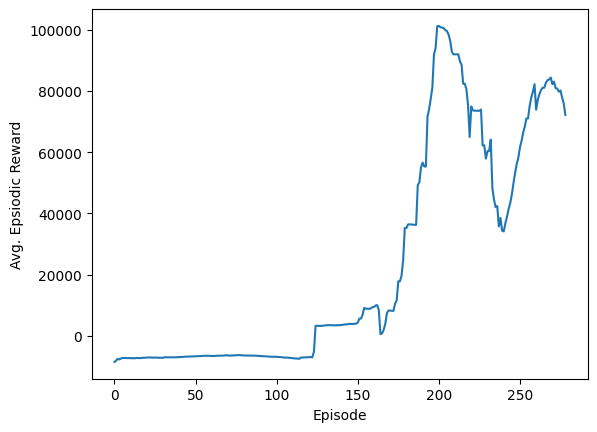

NameError: name 'exit' is not defined

In [35]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Set to negative to disable slowing down
FPS = 60

try:
    # Takes about 4 min to train
    for ep in range(total_episodes):

        prev_state, info = env.reset()
        episodic_reward = 0
        step_count = 0

        while True:
            step_count += 1
            # Only slow it down at the very beginning and the very end
            if len(ep_reward_list) < 3 or len(ep_reward_list) > total_episodes - total_episodes/8:
                # Slow it down so we mere humans can see it
                if FPS > 0:
                    time.sleep(1/FPS)

            # Show the enviorment as it's updated
            env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = policy(tf_prev_state, noise)

            # Recieve state and reward from environment.
            state, reward, done, _, info = env.step(action)

            # Incentivize longer sessions
            # Initial: 0 | stable: step_count
            reward += step_count
            # Initial: 1 | stable: 5
            reward *= 5
            # Initial: 0 | stable: 300
            reward -= 300

            buffer.record((prev_state, action, reward, state))
            episodic_reward += reward

            buffer.learn()
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)

            # End this episode when `done` is True
            if done:
                break

            prev_state = state

        ep_reward_list.append(episodic_reward)

        # Mean of last 40 episodes
        avg_reward = np.mean(ep_reward_list[-40:])
        print(f"Episode {ep:.2f}: Avg Reward is \t{avg_reward}")
        avg_reward_list.append(avg_reward)

# Make sure the window closes if we finish or if there's an error
finally:
    # Plotting graph
    # Episodes versus Avg. Rewards
    plt.plot(avg_reward_list)
    plt.xlabel("Episode")
    plt.ylabel("Avg. Epsiodic Reward")
    plt.show()
    env.close()

If training proceeds correctly, the average episodic reward will increase with time.

Feel free to try different learning rates, `tau` values, and architectures for the
Actor and Critic networks.

The Inverted Pendulum problem has low complexity, but DDPG work great on many other
problems.

Another great environment to try this on is `LunarLandingContinuous-v2`, but it will take
more episodes to obtain good results.

In [ ]:
# Save the weights
actor_model.save_weights("pendulum_actor.h5")
critic_model.save_weights("pendulum_critic.h5")

target_actor.save_weights("pendulum_target_actor.h5")
target_critic.save_weights("pendulum_target_critic.h5")